# Import Libraries

Modify the code to have all the below iterations - 
1. with L1 + BN
2. with L2 + BN
3. with L1 and L2 with BN
4. with GBN
5. with L1 and L2 with GBN


some observations - 
1. Switching from L2 to L1 regularization dramatically reduces the delta between test loss and training loss.
2. Switching from L2 to L1 regularization dampens all of the learned weights.
3. Increasing the L1 regularization rate generally dampens the learned weights; however, if the regularization rate goes too high, the model can't converge and losses are very high.
 


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# !pip install torchviz
# !pip3 install graphviz

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [7]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [8]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [9]:
dropout_value = 0.00
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

## Ghost Batch normalization

In [11]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=False):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [12]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [13]:
class NetWithGBN(nn.Module):
    def __init__(self, dropout_value: int):
        super(NetWithGBN, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            GhostBatchNorm(10, 2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            GhostBatchNorm(10,2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10, 2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,2), 
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,2), 
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16, 2), 
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(16, 2),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = NetWithGBN(dropout_value=0.0).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
    GhostBatchNorm-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
    GhostBatchNorm-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
   GhostBatchNorm-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

In [15]:
# !pip install hiddenlayer
# import hiddenlayer as hl
# # hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [16]:
from tqdm import tqdm

class Trainer():

  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []

  def train(self, model, device, train_loader, optimizer, epoch, lambda_l1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      # L2 loss

      # L1 loss
      l1 = 0
      # lambda_l1 = 0.05
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Learning rate for onecycle LR # Vamsi - added
      # scheduler.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Train set: Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)

  def test(self, model, device, test_loader):
      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      self.test_acc.append(100. * correct / len(test_loader.dataset))

  def getValues(self):
    return (self.train_losses, self.test_losses, self.train_acc, self.test_acc)

  def get_misclassified(self, model, test_loader, device):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
          # move them to the respective device
          data, target = data.to(device), target.to(device)
          # do inferencing
          output = model(data)
          # get the predicted output
          pred = output.argmax(dim=1, keepdim=True)

          # get the current misclassified in this batch
          list_misclassified = (pred.eq(target.view_as(pred)) == False)
          batch_misclassified = data[list_misclassified]
          batch_mis_pred = pred[list_misclassified]
          batch_mis_target = target.view_as(pred)[list_misclassified]

          misclassified.append(batch_misclassified)
          misclassified_pred.append(batch_mis_pred)
          misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [17]:
def plot_metrics(train_losses, train_acc, test_losses, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(14, 16))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()

# Let's Train and test our model

In [18]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [19]:
model_gbn =  NetWithGBN(dropout_value=0.01).to(device)
model_bn =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-3)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
bn_l1
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.1045062467455864 Batch_id=468 Accuracy=85.79: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9809/10000 (98.09%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.0975344106554985 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 9851/10000 (98.51%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.057078976184129715 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9888/10000 (98.88%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.13695310056209564 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9895/10000 (98.95%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.11183291673660278 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9879/10000 (98.79%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.1391158401966095 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9865/10000 (98.65%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=0.028405949473381042 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9932/10000 (99.32%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.038491785526275635 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9937/10000 (99.37%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.06346289813518524 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9938/10000 (99.38%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.06041566655039787 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9930/10000 (99.30%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.04623847082257271 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9939/10000 (99.39%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.08833686262369156 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=0.05339566245675087 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9938/10000 (99.38%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.027317827567458153 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9941/10000 (99.41%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.03107661008834839 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9941/10000 (99.41%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.045524731278419495 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9947/10000 (99.47%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.07198741286993027 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9938/10000 (99.38%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.036241356283426285 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9936/10000 (99.36%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=0.026937289163470268 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9941/10000 (99.41%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.05533092841506004 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9937/10000 (99.37%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.03742499276995659 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9936/10000 (99.36%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.022387301549315453 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9936/10000 (99.36%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.044437263160943985 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9940/10000 (99.40%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.05091718211770058 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9939/10000 (99.39%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=0.08988400548696518 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]



Test set: Average loss: 0.0319, Accuracy: 9940/10000 (99.40%)

Total Misclassifications : 60


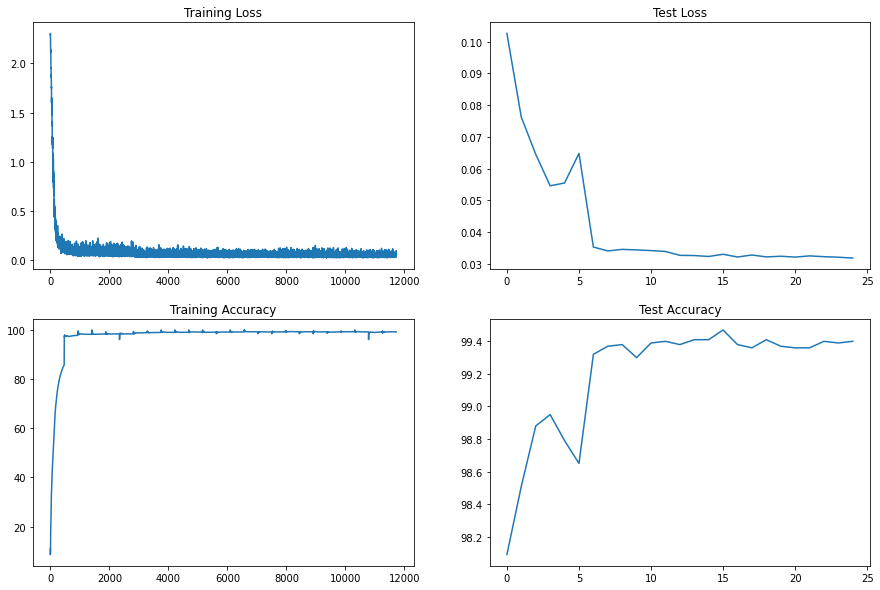

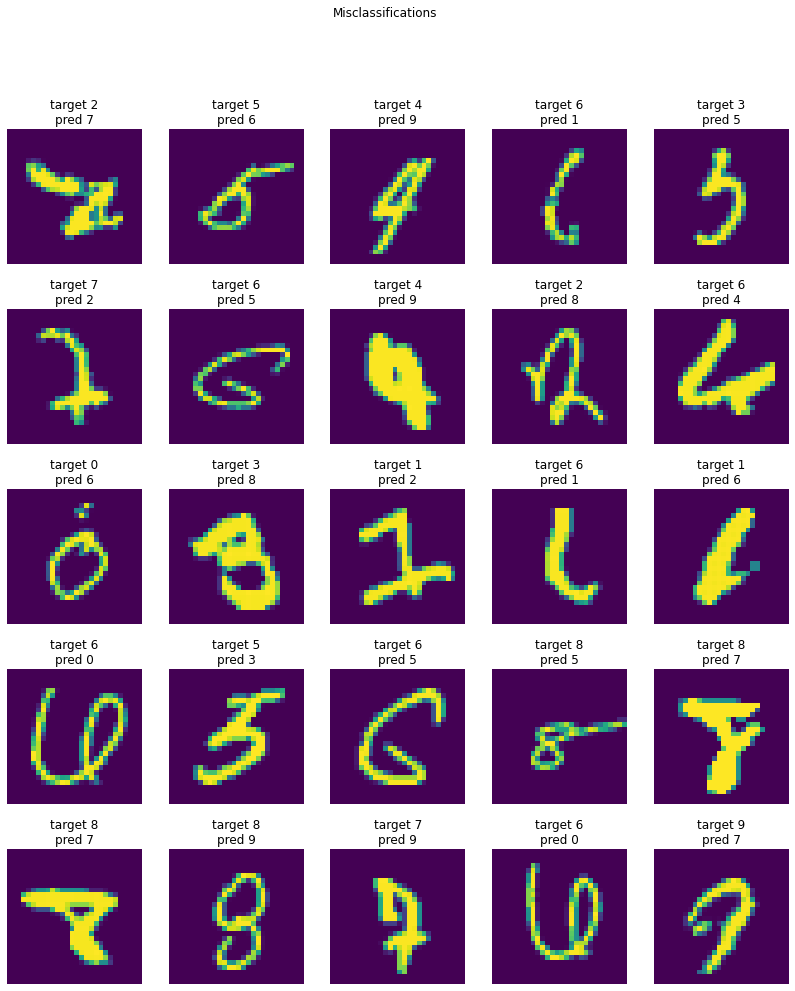

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
bn_l2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.3384122848510742 Batch_id=468 Accuracy=88.35: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9791/10000 (97.91%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.2973337173461914 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1193, Accuracy: 9643/10000 (96.43%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.2162633240222931 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 9793/10000 (97.93%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.24489286541938782 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9792/10000 (97.92%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.19181783497333527 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9835/10000 (98.35%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.21336455643177032 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9787/10000 (97.87%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=0.24535903334617615 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.1870780736207962 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.16862034797668457 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9946/10000 (99.46%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.14003069698810577 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9942/10000 (99.42%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.2764502465724945 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9945/10000 (99.45%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.15652921795845032 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=0.15846672654151917 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.12999147176742554 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.1611701250076294 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.17458787560462952 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.15582925081253052 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.20179875195026398 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=0.15633852779865265 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.14673225581645966 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.17804881930351257 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.14499841630458832 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.14594058692455292 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.21858012676239014 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=0.14373478293418884 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]



Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.44%)

Total Misclassifications : 56


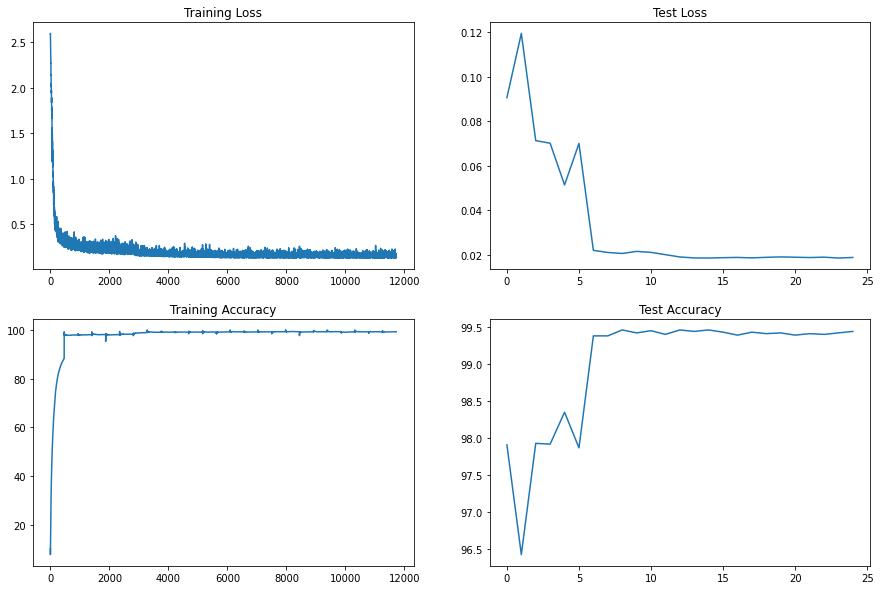

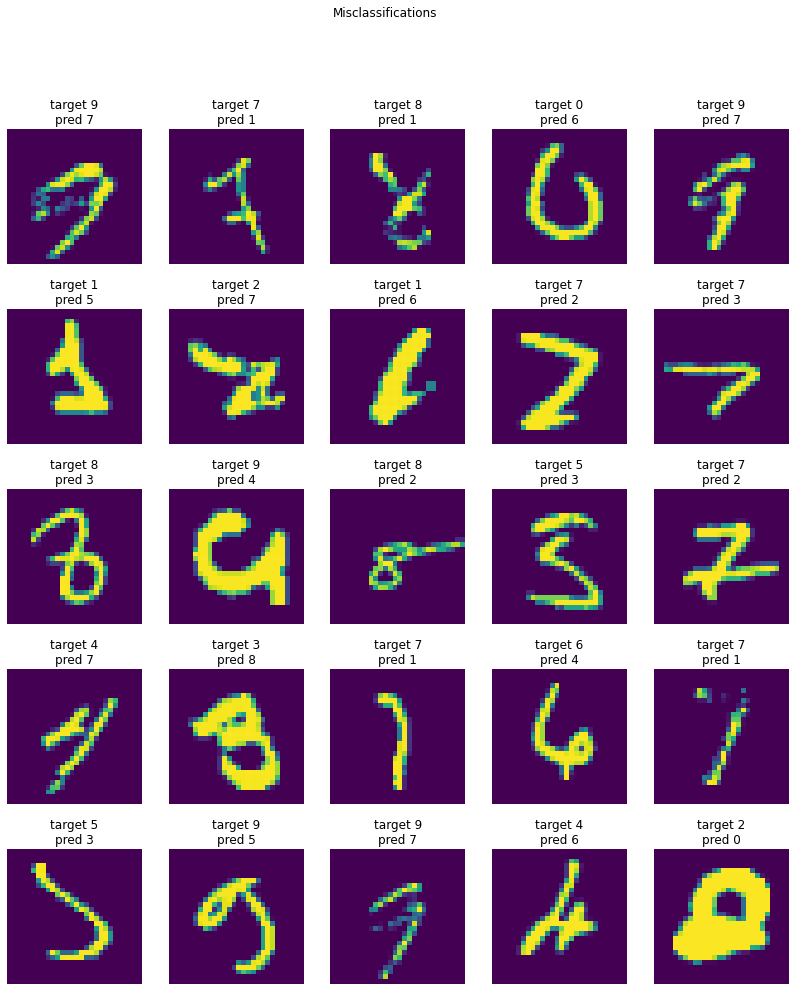

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
bn_l1_l2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.33397364616394043 Batch_id=468 Accuracy=88.27: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1207, Accuracy: 9738/10000 (97.38%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.26784902811050415 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1162, Accuracy: 9732/10000 (97.32%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.19449131190776825 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1259, Accuracy: 9713/10000 (97.13%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.26057469844818115 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9848/10000 (98.48%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.21654579043388367 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9859/10000 (98.59%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.15028315782546997 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0987, Accuracy: 9798/10000 (97.98%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=0.16271859407424927 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9915/10000 (99.15%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.12031590193510056 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9920/10000 (99.20%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.16036522388458252 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9928/10000 (99.28%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.12068407237529755 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9941/10000 (99.41%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.13564851880073547 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9935/10000 (99.35%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.15209859609603882 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9929/10000 (99.29%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=0.11383572220802307 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9940/10000 (99.40%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.14183829724788666 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9940/10000 (99.40%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.10888774693012238 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9939/10000 (99.39%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.1014632135629654 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9941/10000 (99.41%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.10746519267559052 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9944/10000 (99.44%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.1349455714225769 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9941/10000 (99.41%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=0.10006266087293625 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9942/10000 (99.42%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.13532386720180511 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9941/10000 (99.41%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.1289377510547638 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9940/10000 (99.40%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.11362938582897186 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9942/10000 (99.42%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.14429248869419098 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9942/10000 (99.42%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.16857370734214783 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9939/10000 (99.39%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=0.10111641883850098 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]



Test set: Average loss: 0.0333, Accuracy: 9945/10000 (99.45%)

Total Misclassifications : 55


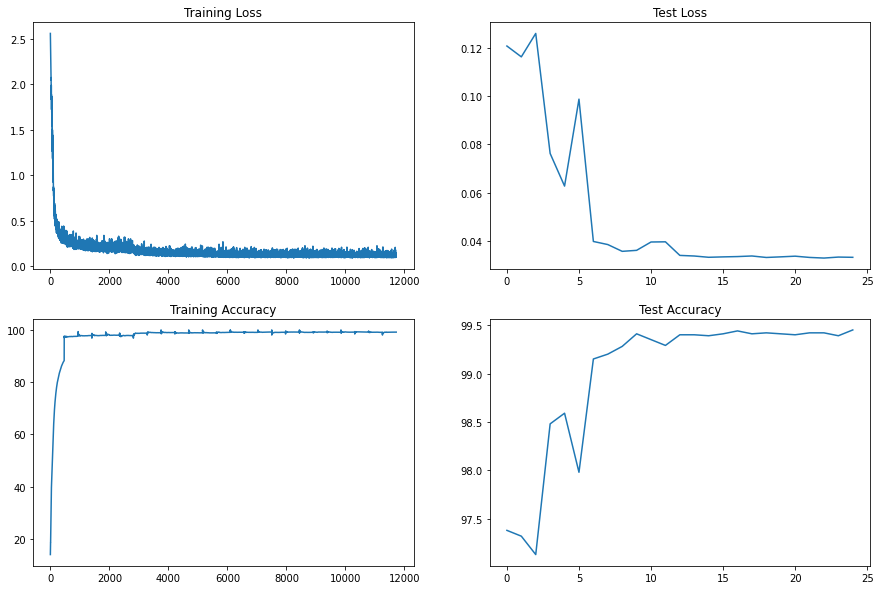

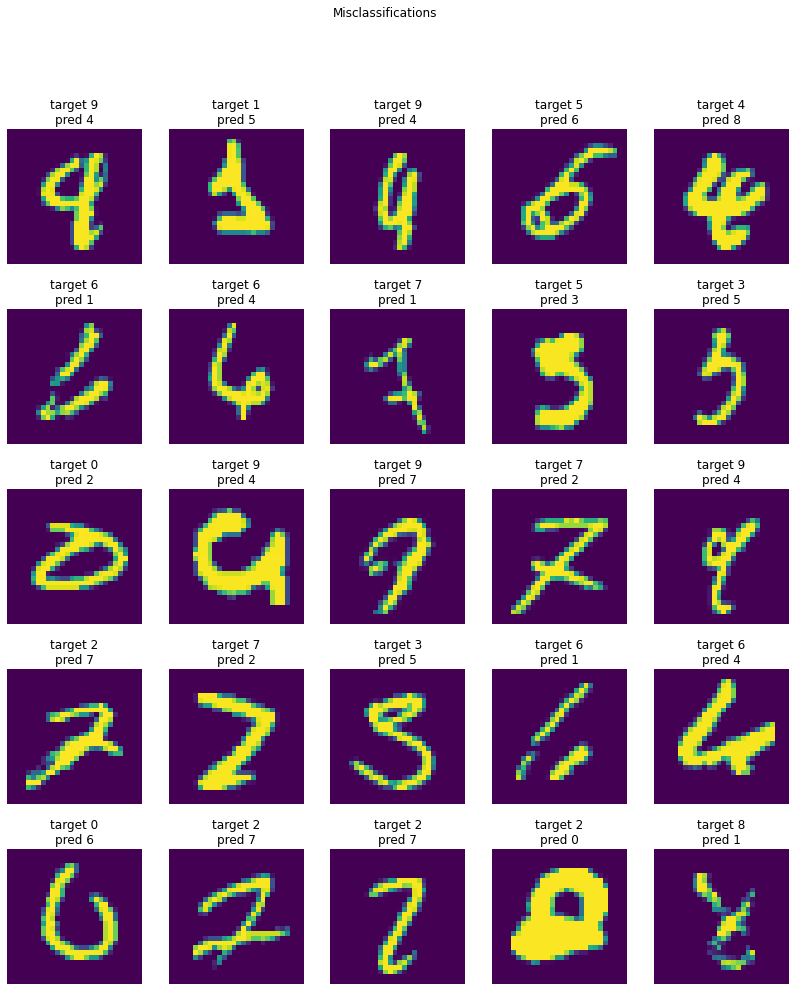

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
gbn
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.18716107308864594 Batch_id=468 Accuracy=86.08: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0827, Accuracy: 9786/10000 (97.86%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.21688425540924072 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9835/10000 (98.35%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.07506544888019562 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9888/10000 (98.88%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.0179982278496027 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9909/10000 (99.09%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.11263187974691391 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.021845968440175056 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9936/10000 (99.36%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=0.02525869943201542 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9948/10000 (99.48%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.03818230703473091 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.0893867239356041 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.01887861266732216 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9943/10000 (99.43%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.04603813588619232 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.013961571268737316 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=0.0896410271525383 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9946/10000 (99.46%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.08263414353132248 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.020552968606352806 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.08481018990278244 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.031698837876319885 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.028246695175766945 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=0.006915162783116102 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.016709305346012115 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9949/10000 (99.49%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.03174247965216637 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.013734028674662113 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.016963321715593338 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9952/10000 (99.52%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.02829407900571823 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9946/10000 (99.46%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=0.0774066224694252 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]



Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

Total Misclassifications : 53


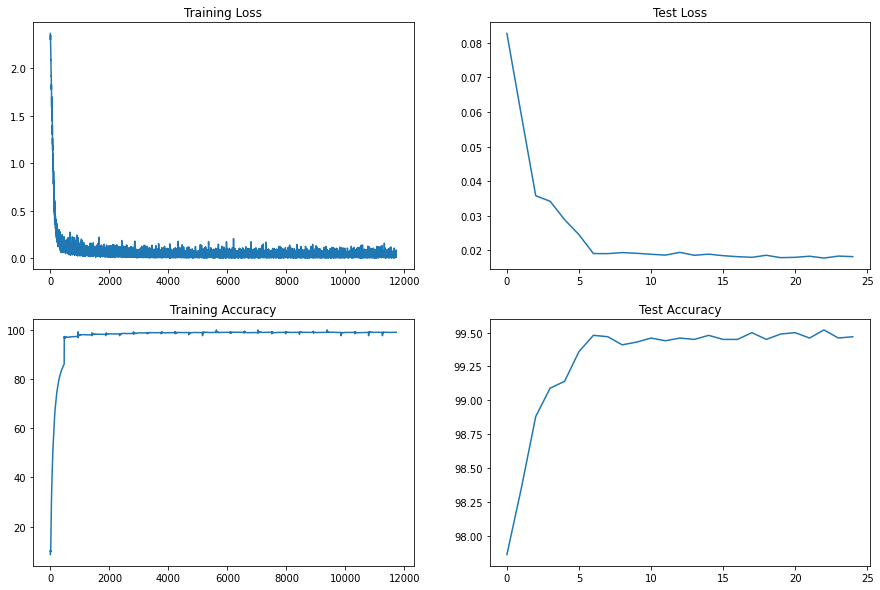

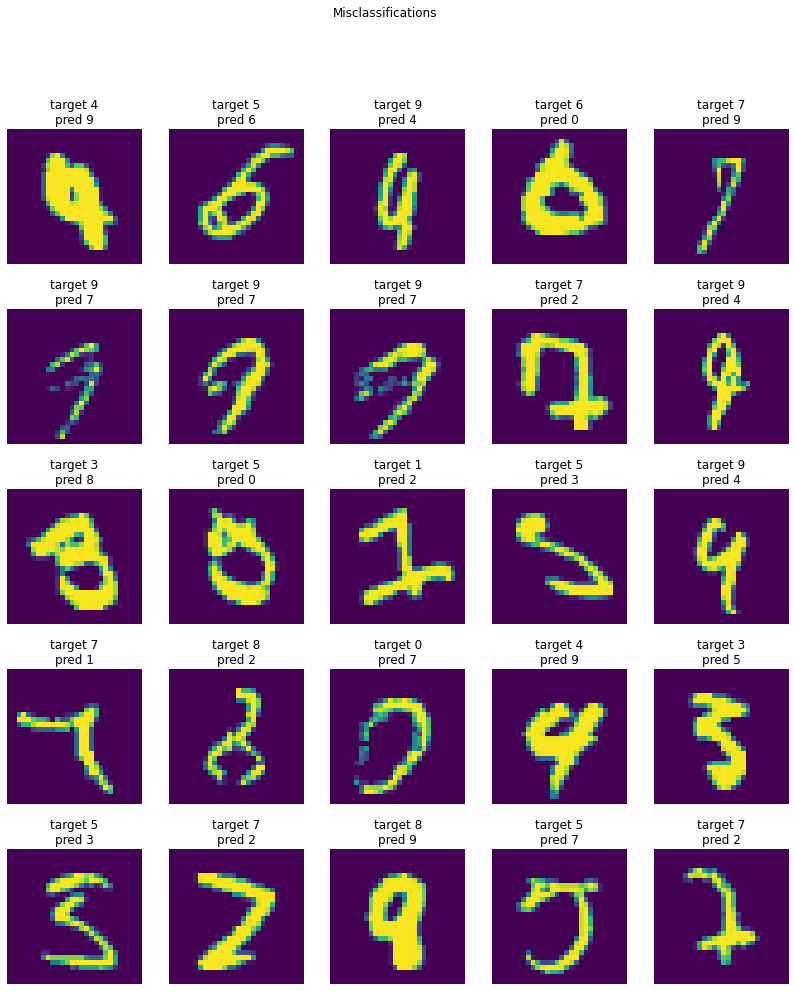

  0%|          | 0/469 [00:00<?, ?it/s]


-----------------------------------------------

-----------------------------------------------
gbn_l1_l2
EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.32923293113708496 Batch_id=468 Accuracy=84.32: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1252, Accuracy: 9772/10000 (97.72%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.3913460373878479 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9817/10000 (98.17%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.1928505301475525 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9795/10000 (97.95%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.17591212689876556 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0869, Accuracy: 9802/10000 (98.02%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.1769101917743683 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 9783/10000 (97.83%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=0.19091695547103882 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0934, Accuracy: 9795/10000 (97.95%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=0.22707784175872803 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9932/10000 (99.32%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.13049784302711487 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9926/10000 (99.26%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.1873873621225357 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9931/10000 (99.31%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.1268252581357956 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9930/10000 (99.30%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.18485158681869507 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9922/10000 (99.22%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=0.20379668474197388 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9928/10000 (99.28%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=0.18728819489479065 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9937/10000 (99.37%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.15125888586044312 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9942/10000 (99.42%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.11015583574771881 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9937/10000 (99.37%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.16995179653167725 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9939/10000 (99.39%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.17575305700302124 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9937/10000 (99.37%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=0.1081787645816803 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9944/10000 (99.44%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=0.11029691994190216 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.1826707422733307 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9938/10000 (99.38%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.2096012383699417 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9938/10000 (99.38%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.1298440396785736 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9943/10000 (99.43%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.16598302125930786 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9941/10000 (99.41%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=0.1356460601091385 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9936/10000 (99.36%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=0.13632579147815704 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]



Test set: Average loss: 0.0307, Accuracy: 9941/10000 (99.41%)

Total Misclassifications : 59


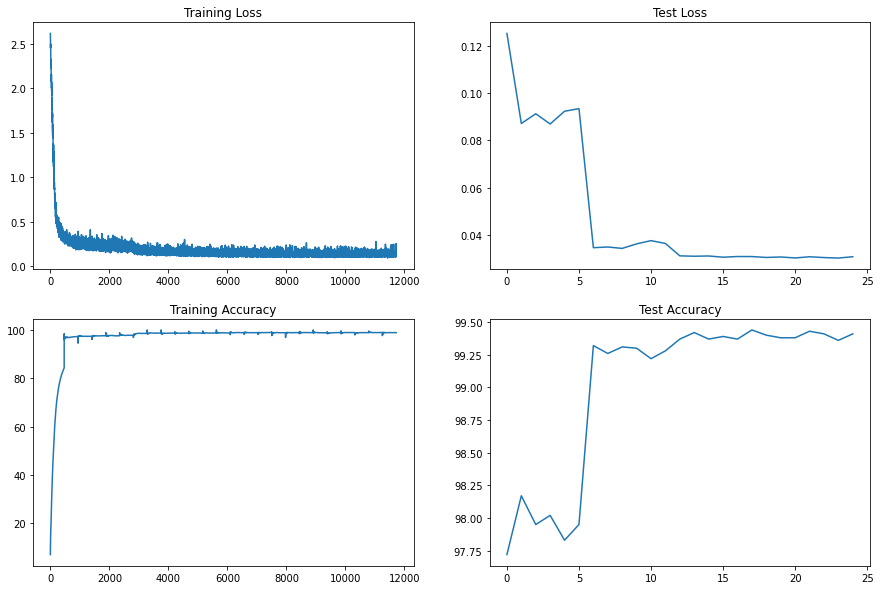

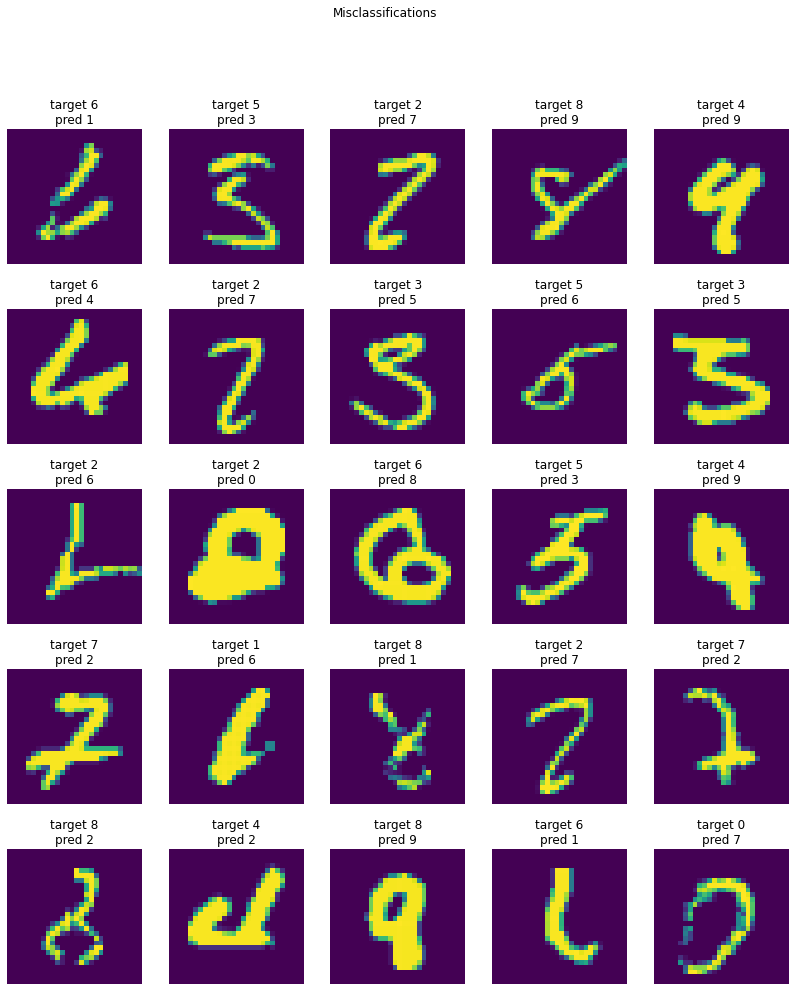

In [20]:
trail_iterations = [('bn_l1', model_bn, 5e-3, 0), ('bn_l2', model_bn, 0, 5e-4), ('bn_l1_l2', model_bn,5e-3, 5e-4) , 
                    ('gbn', model_gbn,0,0), ('gbn_l1_l2', model_gbn, 5e-3, 5e-4)]

metric_acc_values = []
metric_loss_values = []

for i, trail in enumerate(trail_iterations):
  print("\n-----------------------------------------------")
  print("\n-----------------------------------------------")
  print(trail[0])
  EPOCHS = 25
  if i in (0,1,2):
    myModel = Net().to(device)
  else:
    myModel = NetWithGBN(0.01).to(device)
  optimizer = optim.SGD(myModel.parameters(), lr=0.01, momentum=0.9, weight_decay=trail[2])
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

  trainer = Trainer()

  for epoch in range(EPOCHS):
      print("EPOCH:", epoch, "last LR=",scheduler.get_last_lr(), "LR = ", scheduler.get_lr())
      # def train(model, device, train_loader, optimizer, epoch, lambda_l1):
      trainer.train(myModel, device, train_loader, optimizer, epoch, trail[3])
      trainer.test(myModel, device, test_loader)
      scheduler.step() # for StepLR

  (train_losses, test_losses, train_acc, test_acc) = trainer.getValues()

  plot_metrics(train_losses, train_acc, test_losses, test_acc)
  metric_acc_values.extend([test_acc])
  metric_loss_values.extend([test_losses])
  # get_misclassified(self, model, test_loader, device):
  misclassifications = trainer.get_misclassified(myModel, test_loader, device)
  plot_misclassification(misclassified=misclassifications)
  

In [21]:
def plot_acc_loss(acc_loss, msg):
    plt.figure(figsize=(12,12))
    plt.plot(acc_loss[0],color='Red',   label='BN_L1')
    plt.plot(acc_loss[1],color='Blue',     label='BN_L2')
    plt.plot(acc_loss[2],color='Green',    label='BN_L1_L2')
    plt.plot(acc_loss[3],color='Yellow',  label='GBN')
    plt.plot(acc_loss[4],color='Black', label='GBN_L1_L2')
        
    plt.xlabel(' Epochs ')

    if msg == 'Loss':
        plt.ylabel(' Loss ')
        plt.title('Total losses vs Epochs')
    elif msg == 'Acc':
        plt.ylabel(' Accuracy ')
        plt.title('Total accuracy vs Epochs')

    plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))
    plt.legend()
    
    plt.show()

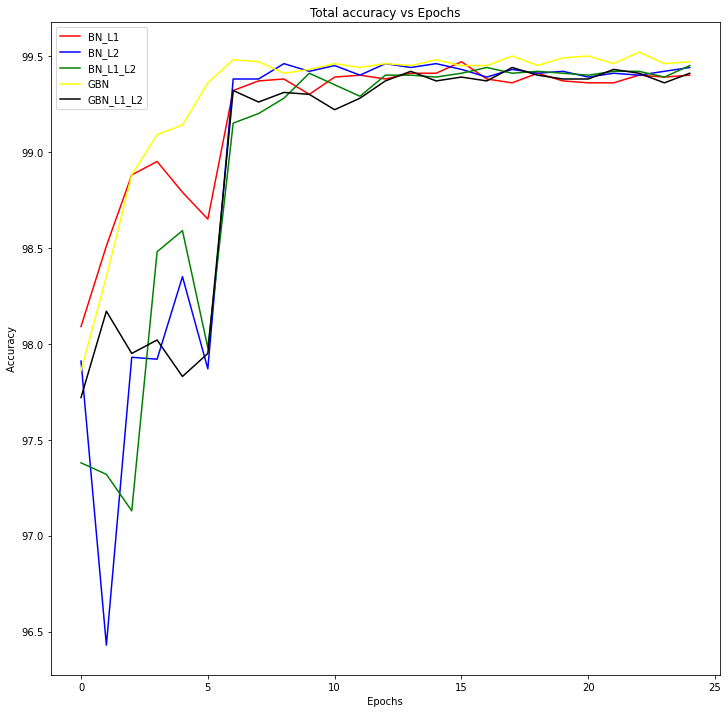

In [22]:
plot_acc_loss(metric_acc_values, "Acc")

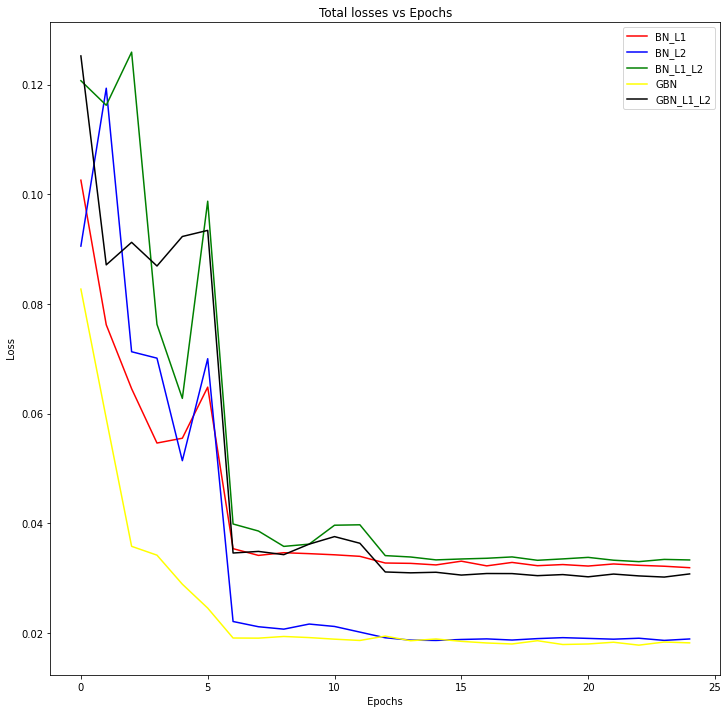

In [23]:
plot_acc_loss(metric_loss_values, "Loss")

In [24]:
metric_loss_values

[[0.10255528292655945,
  0.07618434495031834,
  0.06453079849481583,
  0.05461789705753326,
  0.055496477019786834,
  0.06481683015525341,
  0.03535582014322281,
  0.03412628788650036,
  0.03461663908362388,
  0.03444491230249405,
  0.0342367442548275,
  0.033956574623286724,
  0.03273718713223934,
  0.03267425388693809,
  0.03238927921056747,
  0.03307309909164906,
  0.032216489517688754,
  0.03284459438920021,
  0.03224918908327818,
  0.03245603021383286,
  0.032185706402361396,
  0.03256551807820797,
  0.032320758053660394,
  0.0321503333568573,
  0.03188388070315123],
 [0.09053624076545239,
  0.11933013705313206,
  0.071269797873497,
  0.07009743148237467,
  0.051398808431625365,
  0.06999988055229187,
  0.022069869020581244,
  0.021117439103126526,
  0.020675684332847596,
  0.021605331900715827,
  0.021166829899698494,
  0.02013844630718231,
  0.019105019818991424,
  0.01867564866952598,
  0.018615035520121455,
  0.018792491310089827,
  0.018901016643363983,
  0.018690315162763,
 

In [25]:
metric_acc_values

[[98.09,
  98.51,
  98.88,
  98.95,
  98.79,
  98.65,
  99.32,
  99.37,
  99.38,
  99.3,
  99.39,
  99.4,
  99.38,
  99.41,
  99.41,
  99.47,
  99.38,
  99.36,
  99.41,
  99.37,
  99.36,
  99.36,
  99.4,
  99.39,
  99.4],
 [97.91,
  96.43,
  97.93,
  97.92,
  98.35,
  97.87,
  99.38,
  99.38,
  99.46,
  99.42,
  99.45,
  99.4,
  99.46,
  99.44,
  99.46,
  99.43,
  99.39,
  99.43,
  99.41,
  99.42,
  99.39,
  99.41,
  99.4,
  99.42,
  99.44],
 [97.38,
  97.32,
  97.13,
  98.48,
  98.59,
  97.98,
  99.15,
  99.2,
  99.28,
  99.41,
  99.35,
  99.29,
  99.4,
  99.4,
  99.39,
  99.41,
  99.44,
  99.41,
  99.42,
  99.41,
  99.4,
  99.42,
  99.42,
  99.39,
  99.45],
 [97.86,
  98.35,
  98.88,
  99.09,
  99.14,
  99.36,
  99.48,
  99.47,
  99.41,
  99.43,
  99.46,
  99.44,
  99.46,
  99.45,
  99.48,
  99.45,
  99.45,
  99.5,
  99.45,
  99.49,
  99.5,
  99.46,
  99.52,
  99.46,
  99.47],
 [97.72,
  98.17,
  97.95,
  98.02,
  97.83,
  97.95,
  99.32,
  99.26,
  99.31,
  99.3,
  99.22,
  99.28,
 